In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from scipy.optimize import minimize
from scipy.stats import norm

# GARCH(1, 1) modell felépítése:

A továbbiakban a GARCH-MIDAS modell építésének akarok megágyazni azzal, hogy megépítek egy GARCH(1, 1) modellt, amit szintén a scipy.optimize.minimize 'l-bfgs-b' által optimalizálok. 

A modell felépítéséhez először is meghatároztam mi a paraméter terünk, amiket becsülni kívánok, és ezekre felírtam a log likelihood függvényt. 

Az innovációkra feltesszük, hogy normális eloszlást követnek.

***
$\mathbf{\text{GARCH(1, 1) model}}$<br>
***
&emsp; $$r_t = \mu + \epsilon_t$$
&emsp; $$\epsilon_t = \sigma_t z_t, \;\;\;\;  where \;\; z_t \sim N{(0, 1)}$$
&emsp; $$\sigma_t^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2 + \beta_1 \sigma_{t-1}^2$$

2.&emsp;Parameter Space: $$\Theta = {(\mu; \alpha_0; \alpha_1; \beta_1)}$$
3.&emsp;Loglikelihood function: $$logL(\Theta) = -\frac{1}{2} \sum \limits _{t=1} ^{T} {(log2\pi + log\sigma_t^2 + \frac{\epsilon_t^2}{\sigma_t^2})}$$
4.&emsp;Parameter optimization: $$\underset{\Theta}{\textrm{arg min}} -logL(\Theta)$$

In [2]:
def garch_filter(alpha0, alpha1, beta1, eps):
    iT = len(eps)
    sigma_2 = np.zeros(iT)
    
    for i in range(iT):
        if i == 0:
            sigma_2[i] = alpha0/(1 - alpha1 - beta1)
        else:
            sigma_2[i] = alpha0 + alpha1*eps[i - 1]**2 + beta1*sigma_2[i - 1]
            
    return sigma_2

def garch_loglike(vP, eps):
    alpha0 = vP[0]
    alpha1 = vP[1]
    beta1 = vP[2]
    mu = vP[3]
    
    sigma_2 = garch_filter(alpha0, alpha1, beta1, eps)
    
    logL = len(eps)/2*np.log(2*np.pi) + 0.5*np.sum(np.log(sigma_2)) + 0.5 * np.sum((eps - mu)**2 / sigma_2)
    
    return logL

def garch_constraint(vP, eps):
    alpha1 = vP[1]
    beta1 = vP[2]
    return array([1 - alpha1 - beta1])

def garch_fit(init_params, X):
    res = minimize(garch_loglike, init_params, args = (X), 
                   bounds = ((0.0001, None), (0.0001, None), (0.0001, None), (None, None)), 
                   constraints = {'type': 'eq', 'fun': garch_constraint},
                   options = {'disp': False}, method = 'l-bfgs-b')
    return res

In [3]:
df = pd.read_csv('C:/Users/peter/Desktop/volatiltiy-forecasting/data/Stocks/AMD.csv')
df['Chg'] = np.log(df.close).diff().fillna(0)
returns = df.Chg[1:].values
df['Date'] = pd.to_datetime(df.iloc[:,0])

In [4]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(returns)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -27.353927
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [5]:
vP0 = (0.1, 0.05, 0.92, 0)
garch_out = garch_fit(vP0, returns)
garch_out

C:\Users\peter\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:536: RuntimeWarning: Method l-bfgs-b cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


      fun: -9578.542278411689
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.32147416e+05, 4.58749128e-01, 3.97449183e-01, 2.06819095e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 345
      nit: 44
     njev: 69
   status: 0
  success: True
        x: array([1.00000000e-04, 1.16047043e-01, 8.39474687e-01, 2.84893478e-04])

In [6]:
print('Estimated Parameters from GARCH(1, 1):',
      '\n\nMu:\t', round(garch_out.x[3], 4),
      '\nAlpha0:\t', round(garch_out.x[0], 4), 
      '\nAlpha1:\t', round(garch_out.x[1], 4), 
      '\nBeta1:\t', round(garch_out.x[2], 4))

Estimated Parameters from GARCH(1, 1): 

Mu:	 0.0003 
Alpha0:	 0.0001 
Alpha1:	 0.116 
Beta1:	 0.8395


In [7]:
mu_est = garch_out.x[3]
alpha0_est = garch_out.x[0]
alpha1_est = garch_out.x[1]
beta1_est = garch_out.x[2]
sigma2_garch = garch_filter(alpha0_est, alpha1_est, beta1_est, returns)*np.sqrt(252)

In [8]:
print('AIC of GARCH: ', 2*3 - 2*np.log(-garch_loglike(garch_out.x, returns)))

AIC of GARCH:  -12.3345613927638


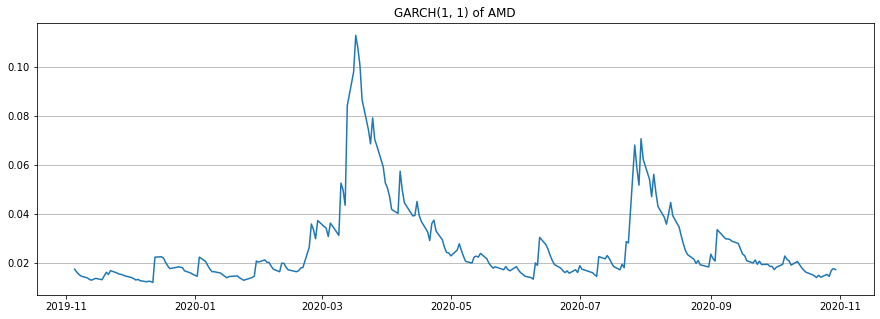

In [9]:
plt.figure(figsize=(15,5))
plt.plot(df.Date[-250:], sigma2_garch[-250:])
plt.title('GARCH(1, 1) of AMD')
plt.grid(axis = 'y')
plt.show()

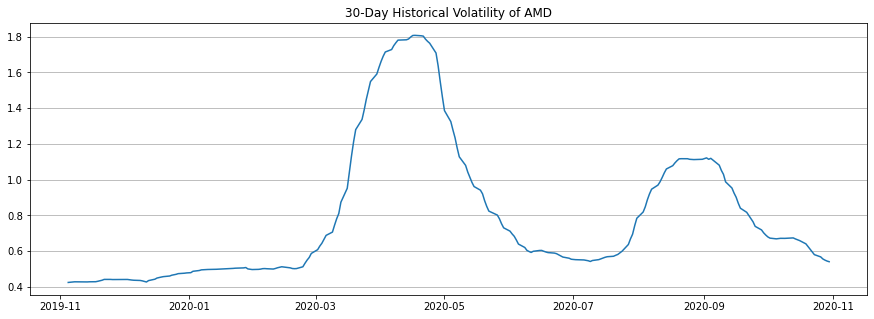

In [10]:
plt.figure(figsize=(15,5))
plt.plot(df.Date[-250:],pd.Series(sigma2_garch).rolling(30).sum()[-250:])
plt.title('30-Day Historical Volatility of AMD')
plt.grid(axis = 'y')
plt.show()

Szemmel látható, hogy a hozamok nem követnek normális eloszlást, így a továbbiakban próbálkozok egy olyan modellt illeszteni, ami egy Student-t eloszlást követ.

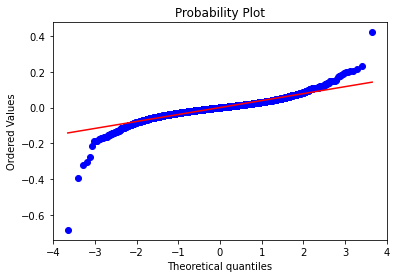

In [11]:
from scipy import stats

stats.probplot(returns, plot=plt)
plt.show()

## Student-t eloszlású GARCH(1, 1)

Itt az innovációkra tesszük fel, hogy nem normális eloszlásúak, hanem Student-t a megfelelő paraméterrel.

#### A loglikelihood függvényünket kell átírni erre az alkalra elméletileg:

$$logL(\Theta) = log{[\Gamma(\frac{\nu + 1}{2})]} -log{[\Gamma(\frac{\nu}{2})]} -\frac{1}{2}log{[\pi(\nu - 2)]} - \frac{1}{2}\sum \limits _ {t=1} ^N {[log(\sigma_t^2) + (1 + \nu)log{(1 + \frac{\epsilon_t^2}{\nu -2})}]}$$

A következő cikk alapján:<br>
Peters, J.-P. (2001). Estimating and forecasting volatility of stock indices using asymmetric
GARCH models and (Skewed) Student-t densities. University of Liège.<br>
Letölthető:<br>
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.465.87&rep=rep1&type=pdf

#### A Paraméter terünk ekkor:

$$\Theta = {(\mu; \alpha_0; \alpha_1; \beta_1; \nu)}, \;\;\;\; where \;\; \nu > 2$$

In [63]:
from scipy.special import gamma

def t_garch_filter(alpha0, alpha1, beta1, eps):
    iT = len(eps)
    sigma_2 = np.zeros(iT)
    
    for i in range(iT):
        if i == 0:
            sigma_2[i] = alpha0/(1 - alpha1 - beta1)
        else:
            sigma_2[i] = alpha0 + alpha1*eps[i - 1]**2 + beta1*sigma_2[i - 1]
            
    return sigma_2

def t_garch_loglike(vP, eps):
    alpha0 = vP[0]
    alpha1 = vP[1]
    beta1 = vP[2]
    v = vP[3]
    mu = vP[4]
    
    sigma_2 = t_garch_filter(alpha0, alpha1, beta1, eps)
    
    logL = np.log(gamma((v + 1)/2)) - np.log(gamma(v/2)) - np.log(np.pi*(v - 2))/2 - 1/2*np.sum(np.log(sigma_2) + (1+v)*np.log(1+(eps - mu)**2/(sigma_2*(v-2))))
    
    return -logL

def garch_constraint(vP, eps):
    alpha1 = vP[1]
    beta1 = vP[2]
    return array([1 - alpha1 - beta1])

def t_garch_fit(init_params, X):
    res = minimize(t_garch_loglike, init_params, args = (X), 
                   bounds = ((0.0001, None), (0.0001, None), (0.0001, None), (2.00001, None), (None, None)), 
                   constraints = {'type': 'eq', 'fun': garch_constraint},
                   tol = 10e-16,
                   options = {'disp': True},
                   method = 'l-bfgs-b')
    return res

In [64]:
vP0 = (0.1, 0.05, 0.92, 3, 0)
t_garch_out = t_garch_fit(vP0, returns)

<ipython-input-63-5b7fad9a762d>:24: RuntimeWarning: invalid value encountered in log
  logL = np.log(gamma((v + 1)/2)) - np.log(gamma(v/2)) - np.log(np.pi*(v - 2))/2 - 1/2*np.sum(np.log(sigma_2) + (1+v)*np.log(1+(eps - mu)**2/(sigma_2*(v-2))))
<ipython-input-63-5b7fad9a762d>:24: RuntimeWarning: invalid value encountered in double_scalars
  logL = np.log(gamma((v + 1)/2)) - np.log(gamma(v/2)) - np.log(np.pi*(v - 2))/2 - 1/2*np.sum(np.log(sigma_2) + (1+v)*np.log(1+(eps - mu)**2/(sigma_2*(v-2))))


In [65]:
t_garch_out

      fun: nan
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.28984987e+05, -3.22464984e+02,  1.21203447e+03, -1.30069039e+03,
        2.69238575e+04])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 96
      nit: 3
     njev: 16
   status: 2
  success: False
        x: array([3.01920648e-04, 4.87628156e-02, 8.27623530e-01, 3.11950806e+00,
       5.80854896e-03])

In [66]:
mu_est3 = t_garch_out.x[4]
alpha0_est3 = t_garch_out.x[0]
alpha1_est3 = t_garch_out.x[1]
beta1_est3 = t_garch_out.x[2]
nu_est3 = t_garch_out.x[3]
sigma2_t_garch = t_garch_filter(alpha0_est3, alpha1_est3, beta1_est3, returns)*np.sqrt(252)

In [67]:
print('AIC of t-GARCH: ', 2*4 - 2*np.log(-t_garch_loglike(t_garch_out.x, returns)))

AIC of t-GARCH:  -10.873573947223719


In [68]:
print('Estimated Parameters from t-GARCH(1, 1):',
      '\n\nMu:\t', round(t_garch_out.x[4], 4),
      '\nAlpha0:\t', round(t_garch_out.x[0], 4), 
      '\nAlpha1:\t', round(t_garch_out.x[1], 4), 
      '\nBeta1:\t', round(t_garch_out.x[2], 4),
      '\nNu:\t', round(t_garch_out.x[3], 4))

Estimated Parameters from t-GARCH(1, 1): 

Mu:	 0.0058 
Alpha0:	 0.0003 
Alpha1:	 0.0488 
Beta1:	 0.8276 
Nu:	 3.1195


Ez a modell már jobban illeszkedik, mint amikor normális eloszlást feltételeztünk:

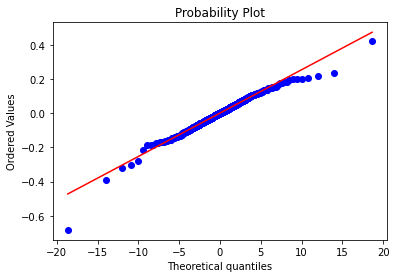

In [57]:
stats.probplot(returns, dist = stats.t(t_garch_out.x[3]), plot=plt)
plt.show()

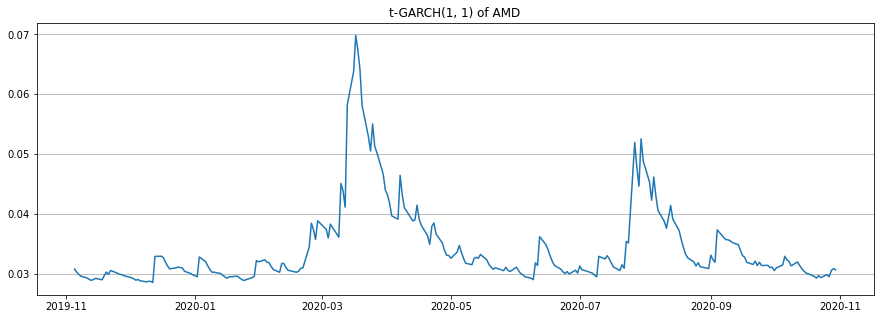

In [19]:
plt.figure(figsize=(15,5))
plt.plot(df.Date[-250:], sigma2_t_garch[-250:])
plt.title('t-GARCH(1, 1) of AMD')
plt.grid(axis = 'y')
plt.show()

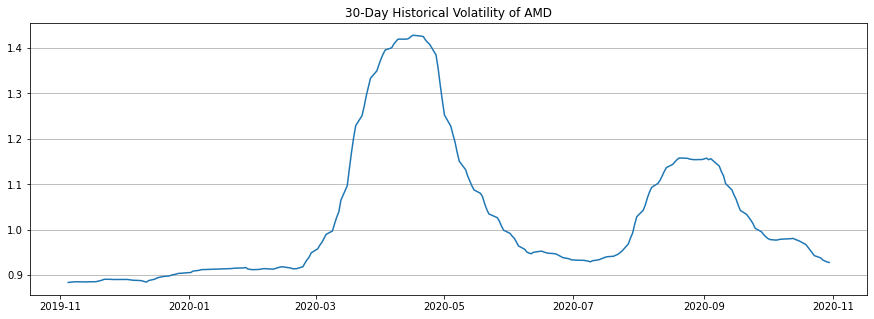

In [20]:
plt.figure(figsize=(15,5))
plt.plot(df.Date[-250:],pd.Series(sigma2_t_garch).rolling(30).sum()[-250:])
plt.title('30-Day Historical Volatility of AMD')
plt.grid(axis = 'y')
plt.show()

link: https://www.alphaquery.com/stock/AMD/volatility-option-statistics/30-day/historical-volatility


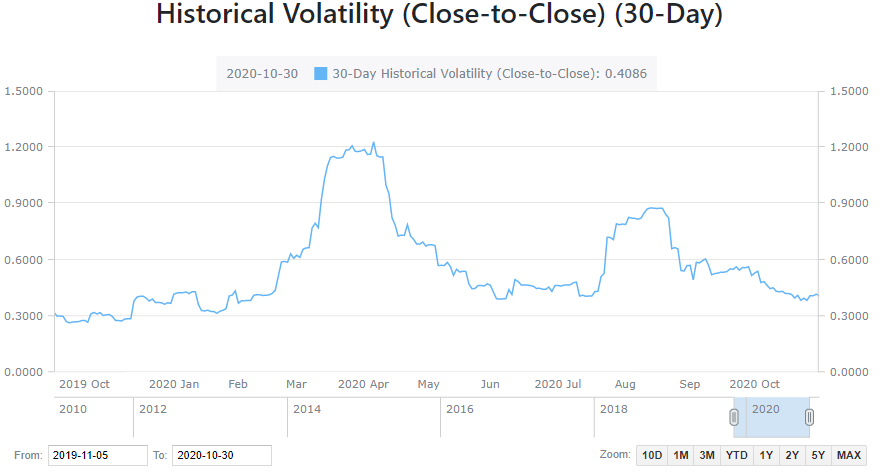

In [21]:
from IPython.display import Image
print('link: https://www.alphaquery.com/stock/AMD/volatility-option-statistics/30-day/historical-volatility')
Image(filename='C:/Users/peter/Documents/AMD.png')